# **Project- Time Series Forecasting with Prophet Algorithm**

In [178]:
import warnings
warnings.filterwarnings("ignore")

In [179]:
!pip install prophet
from prophet import Prophet

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [180]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [181]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [182]:
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

In [183]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

**Data**

The data we will be using is hourly power consumption data from PJM. Energy consumption has some unique characteristics. It will be interesting to see how prophet picks them up.

Pulling the PJM East which has data from 2002-2018 for the entire east region.

In [185]:
pjme=pd.read_csv("A.I. Project Folder/PJME_hourly.csv",
                index_col=[0],
                  parse_dates=[0])
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498
2002-12-31 02:00:00,25147
2002-12-31 03:00:00,24574
2002-12-31 04:00:00,24393
2002-12-31 05:00:00,24860


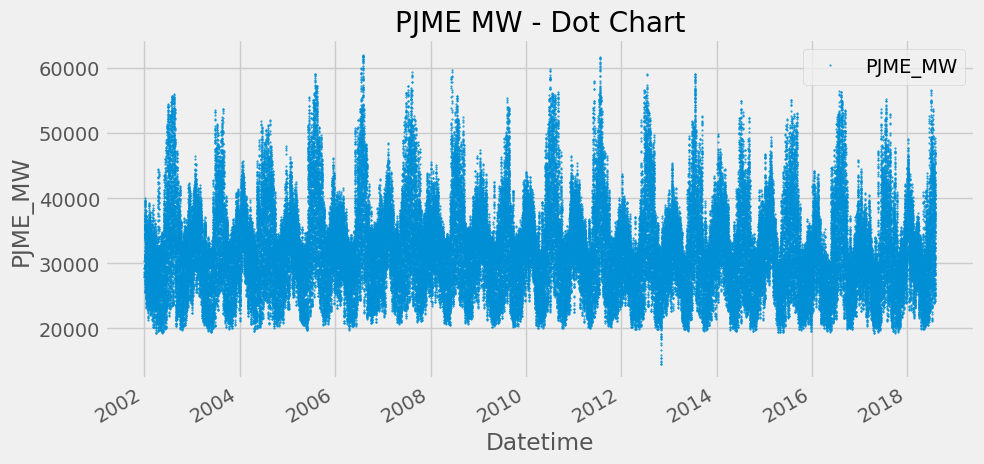

In [186]:
# Dot Chart
pjme.plot(style='.',  # Specify the type of plot as 'dot'
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='PJME MW - Dot Chart')
plt.xlabel('Datetime')  # Add label for the x-axis
plt.ylabel('PJME_MW')   # Add label for the y-axis
plt.show()

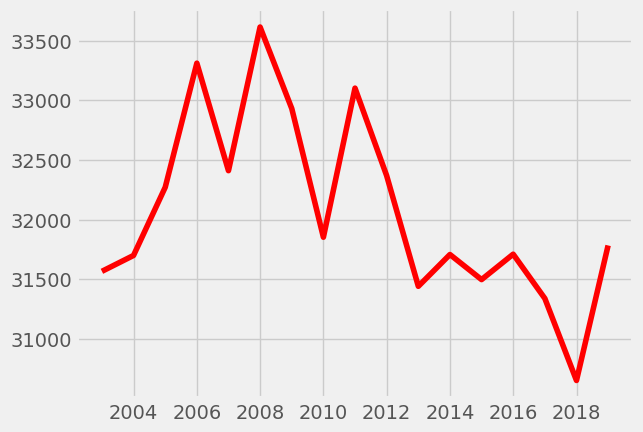

In [137]:
plt.plot(pjme.resample('Y').mean(), label='Yearly Mean', color='red')

# **Time Series Features**

In [187]:
from pandas.api.types import CategoricalDtype

# Define a custom categorical type for weekdays
cat_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)  # Convert to categorical with correct order
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week  # Use isocalendar().week instead of weekofyear
    df['date_offset'] = (df.date.dt.month * 100 + df.date.dt.day - 320) % 1300

    # Create a 'season' feature based on the date_offset
    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter'])

    # Define features (X) and target (y) if label is provided
    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear', 'weekday',
            'season']]
    if label:
        y = df[label]
        return X, y
    return X

# Create features and target
X, y = create_features(pjme, label='PJME_MW')

# Combine features and target into a single DataFrame
features_and_target = pd.concat([X, y], axis=1)

In [188]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,PJME_MW
Datetime,,,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,Tuesday,Winter,26498
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,Tuesday,Winter,25147
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,Tuesday,Winter,24574
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,Tuesday,Winter,24393
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,Tuesday,Winter,24860


In [59]:
from pandas.api.types import CategoricalDtype

# Define a custom categorical type for weekdays (Monday=1, Tuesday=2, etc.)
cat_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    Modifies dayofweek to start from 1 (Monday=1, Tuesday=2, etc.).
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek + 1  # Shift from 0-6 to 1-7
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)  # Convert to categorical with correct order
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date_offset'] = (df.date.dt.month * 100 + df.date.dt.day - 320) % 1300

    # Create a 'season' feature based on the date_offset
    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter'])

    # Define features (X) and target (y) if label is provided
    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear', 'weekday',
            'season']]
    if label:
        y = df[label]
        return X, y
    return X

# Create features and target
X, y = create_features(pjme, label='PJME_MW')

# Combine features and target into a single DataFrame
features_and_target = pd.concat([X, y], axis=1)

In [28]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,PJME_MW
Datetime,,,,,,,,,,,
2002-12-31 01:00:00,1,2,4,12,2002,365,31,1,Tuesday,Winter,26498
2002-12-31 02:00:00,2,2,4,12,2002,365,31,1,Tuesday,Winter,25147
2002-12-31 03:00:00,3,2,4,12,2002,365,31,1,Tuesday,Winter,24574
2002-12-31 04:00:00,4,2,4,12,2002,365,31,1,Tuesday,Winter,24393
2002-12-31 05:00:00,5,2,4,12,2002,365,31,1,Tuesday,Winter,24860


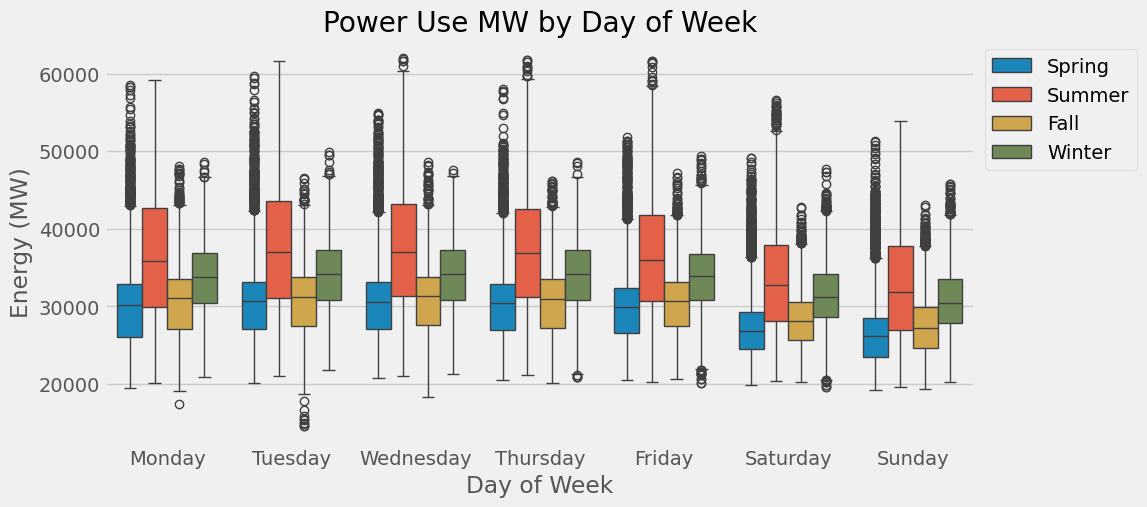

In [189]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

**Train / Test Split**

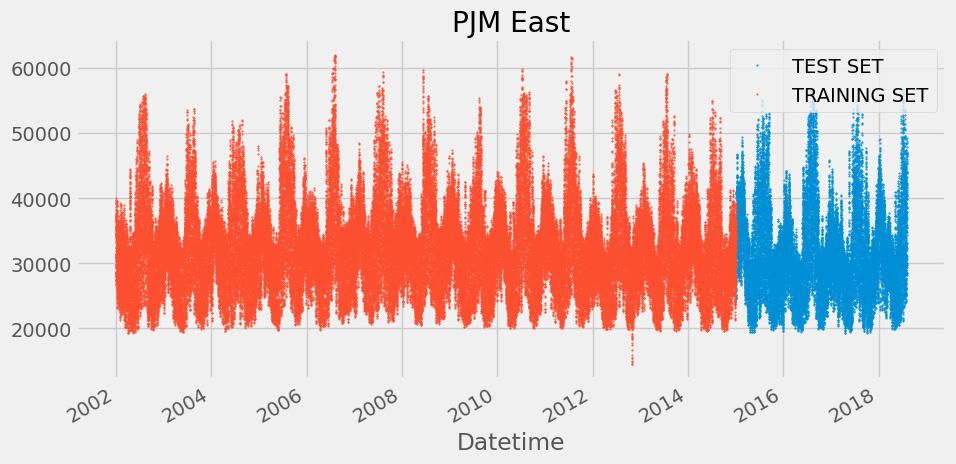

In [190]:
split_date = '1-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='PJM East', style='.', ms=1)
plt.show()

**Simple Prophet Model**

Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.

Datetime column named: ds

target : y

In [191]:
# Format data for prophet model using ds and y
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

In [192]:
pjme_train_prophet.head()

,ds,y
0,2002-12-31 01:00:00,26498
1,2002-12-31 02:00:00,25147
2,2002-12-31 03:00:00,24574
3,2002-12-31 04:00:00,24393
4,2002-12-31 05:00:00,24860


In [193]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

20:33:19 - cmdstanpy - INFO - Chain [1] start processing
20:35:20 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 19.2 s
Wall time: 2min 21s


In [194]:
# Predict on test set with model
pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

pjme_test_fcst = model.predict(pjme_test_prophet)

In [195]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31200.339206,23598.133304,33099.853392,31200.339206,31200.339206,-2842.562168,-2842.562168,-2842.562168,-4430.590454,...,1281.474328,1281.474328,1281.474328,306.553958,306.553958,306.553958,0.0,0.0,0.0,28357.777038
1,2015-01-01 02:00:00,31200.300721,22086.706750,31302.332355,31200.300721,31200.300721,-4347.079710,-4347.079710,-4347.079710,-5927.617356,...,1272.694228,1272.694228,1272.694228,307.843418,307.843418,307.843418,0.0,0.0,0.0,26853.221011
2,2015-01-01 03:00:00,31200.262235,21586.462438,30336.758268,31200.262235,31200.262235,-5218.803832,-5218.803832,-5218.803832,-6790.687108,...,1262.708907,1262.708907,1262.708907,309.174370,309.174370,309.174370,0.0,0.0,0.0,25981.458403
3,2015-01-01 04:00:00,31200.223749,21548.248805,30686.587672,31200.223749,31200.223749,-5360.281813,-5360.281813,-5360.281813,-6922.470785,...,1251.642133,1251.642133,1251.642133,310.546839,310.546839,310.546839,0.0,0.0,0.0,25839.941936
4,2015-01-01 05:00:00,31200.185263,22001.490728,30969.651084,31200.185263,31200.185263,-4685.843322,-4685.843322,-4685.843322,-6237.434051,...,1239.629878,1239.629878,1239.629878,311.960851,311.960851,311.960851,0.0,0.0,0.0,26514.341942


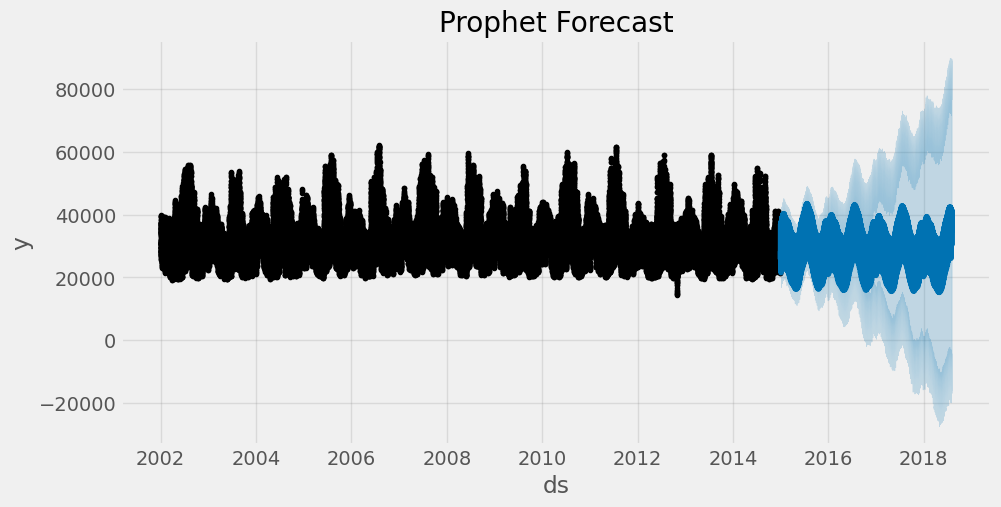

In [196]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

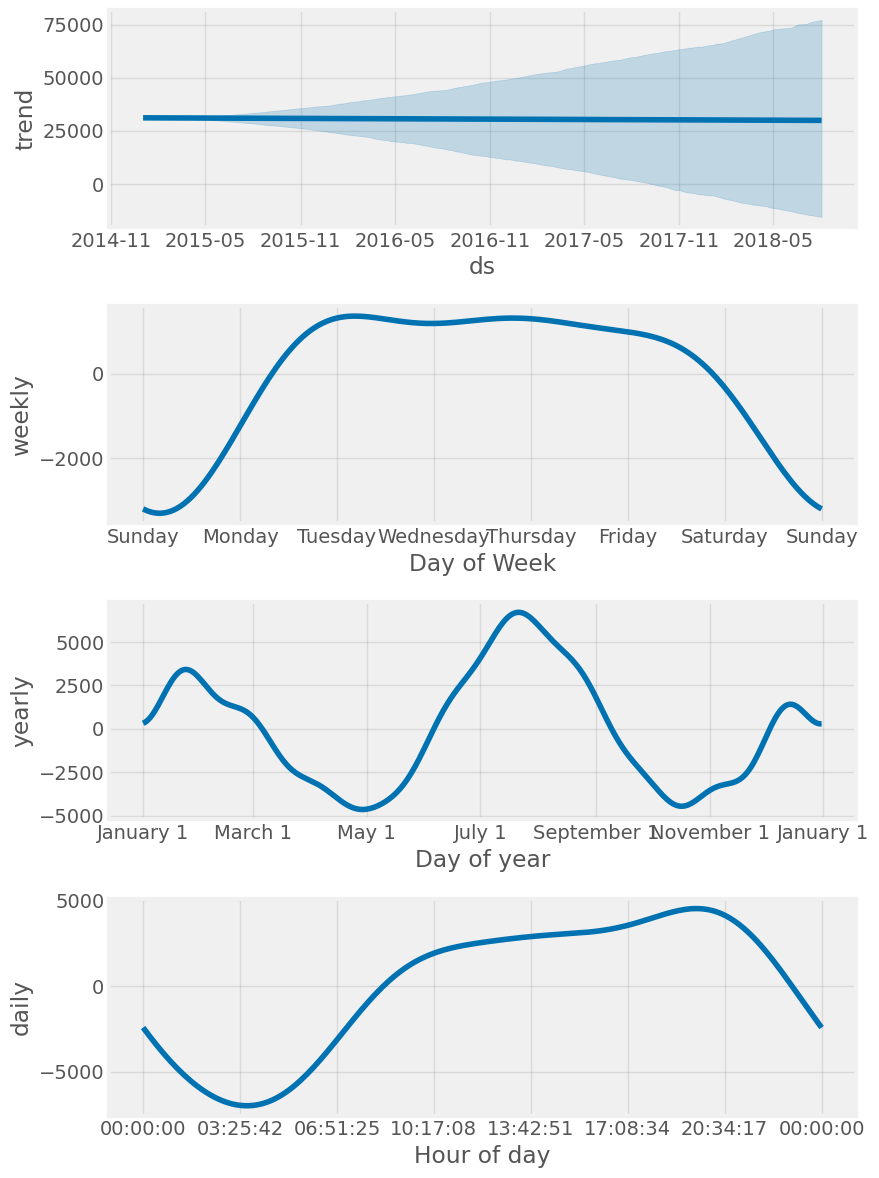

In [197]:
fig = model.plot_components(pjme_test_fcst)
plt.show()

**Compare Forecast to Actuals**

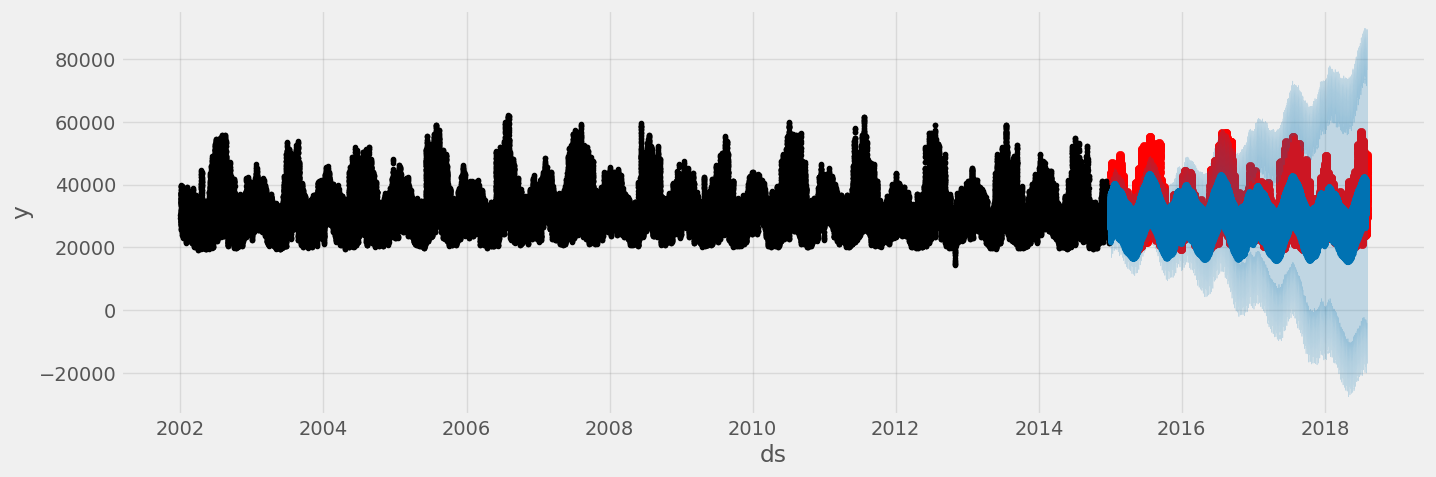

In [198]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

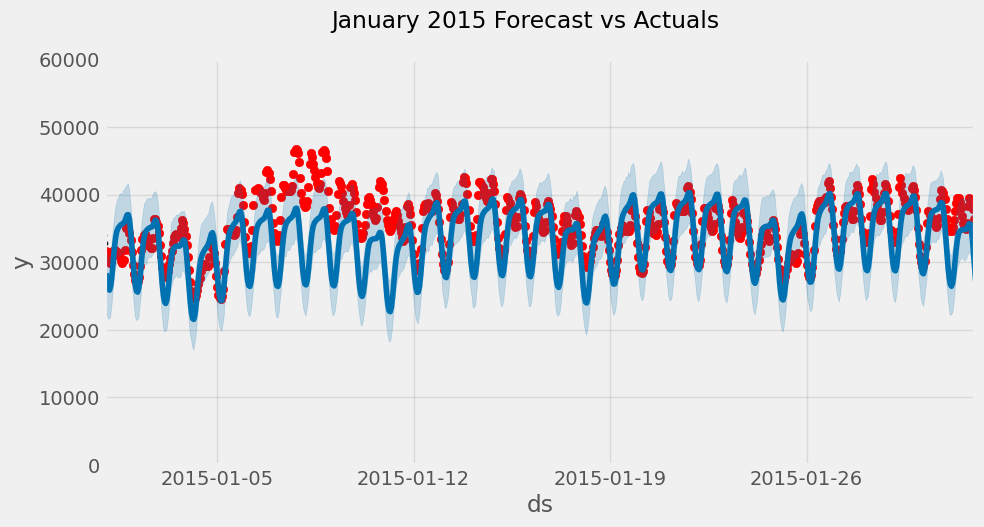

In [199]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

# Convert the date strings to datetime objects using pd.to_datetime
lower_date = pd.to_datetime('2015-01-01')
upper_date = pd.to_datetime('2015-02-01')

ax.set_xbound(lower=lower_date, upper=upper_date)
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')
plt.show() # Add this line to display the plot

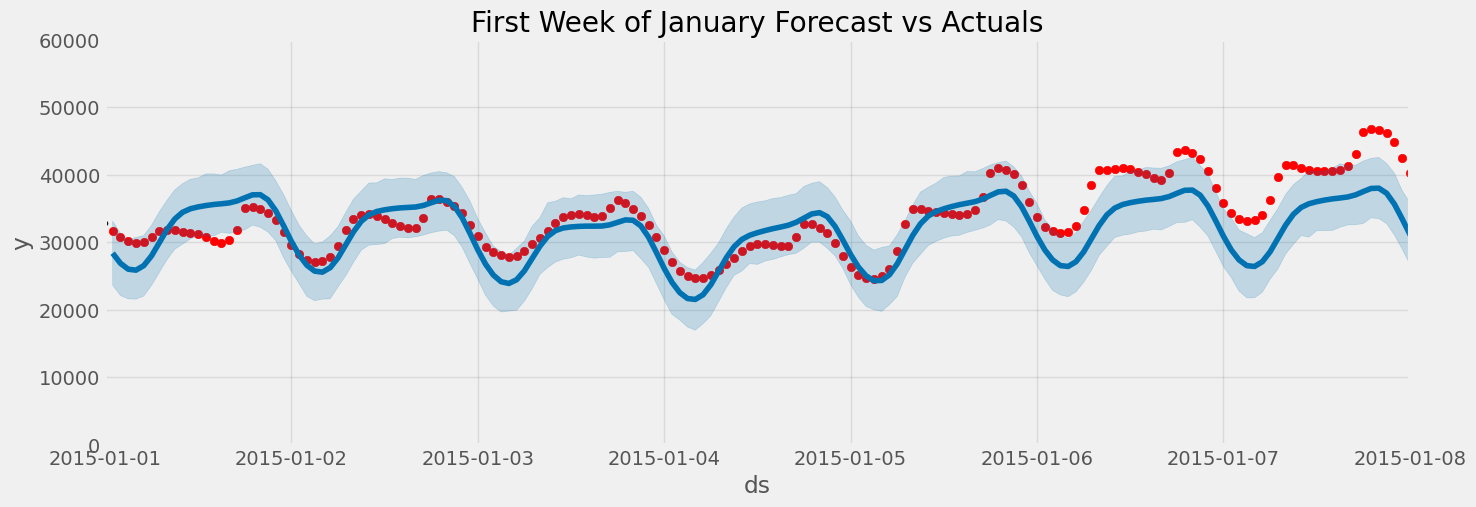

In [200]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

# Convert the date strings to datetime objects using pd.to_datetime
lower_date = pd.to_datetime('2015-01-01')
upper_date = pd.to_datetime('2015-01-08')  # Changed to '2015-01-08'

ax.set_xbound(lower=lower_date, upper=upper_date) # Now using datetime objects
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()

**Evaluate the model with Error Metrics**

In [201]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat']))

np.float64(6619.0084438739295)

In [202]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

5183.308123570645

In [203]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

np.float64(16.505469633679194)

**Adding Holidays**

Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.

We will use the built in pandas USFederalHolidayCalendar to pull the list of holidays

In [204]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays = cal.holidays(start=pjme.index.min(), # First date in the data
                        end=pjme.index.max(), # Last date in the data
                        return_name=True) # Returns holiday names
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [205]:
holidays

2002-01-21    Birthday of Martin Luther King, Jr.
2002-02-18                  Washington's Birthday
2002-05-27                           Memorial Day
2002-07-04                       Independence Day
2002-09-02                              Labor Day
                             ...                 
2018-01-01                         New Year's Day
2018-01-15    Birthday of Martin Luther King, Jr.
2018-02-19                  Washington's Birthday
2018-05-28                           Memorial Day
2018-07-04                       Independence Day
Length: 164, dtype: object

In [206]:
# Assuming the intention is to access the holiday column
holiday_df['holiday'].value_counts()

holiday
Birthday of Martin Luther King, Jr.    17
Washington's Birthday                  17
Memorial Day                           17
Independence Day                       17
Labor Day                              16
Columbus Day                           16
Veterans Day                           16
Thanksgiving Day                       16
Christmas Day                          16
New Year's Day                         16
Name: count, dtype: int64

In [207]:
holiday_df

,ds,holiday
0,2002-01-21,"Birthday of Martin Luther King, Jr."
1,2002-02-18,Washington's Birthday
2,2002-05-27,Memorial Day
3,2002-07-04,Independence Day
4,2002-09-02,Labor Day
...,...,...
159,2018-01-01,New Year's Day
160,2018-01-15,"Birthday of Martin Luther King, Jr."
161,2018-02-19,Washington's Birthday
162,2018-05-28,Memorial Day


In [208]:
holiday_df.reset_index().rename(columns={'index':'ds'})

,ds,ds,holiday
0,0,2002-01-21,"Birthday of Martin Luther King, Jr."
1,1,2002-02-18,Washington's Birthday
2,2,2002-05-27,Memorial Day
3,3,2002-07-04,Independence Day
4,4,2002-09-02,Labor Day
...,...,...,...
159,159,2018-01-01,New Year's Day
160,160,2018-01-15,"Birthday of Martin Luther King, Jr."
161,161,2018-02-19,Washington's Birthday
162,162,2018-05-28,Memorial Day


In [209]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train_prophet)

20:38:01 - cmdstanpy - INFO - Chain [1] start processing
20:40:14 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 21.7 s
Wall time: 2min 35s


In [210]:
# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test_prophet)

In [211]:
pjme_test_fcst_with_hols.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,"Birthday of Martin Luther King, Jr.","Birthday of Martin Luther King, Jr._lower","Birthday of Martin Luther King, Jr._upper",Christmas Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31258.436150,21296.494657,30287.549287,31258.436150,31258.436150,0.0,0.0,0.0,0.0,...,1324.486469,1324.486469,1324.486469,644.962377,644.962377,644.962377,0.0,0.0,0.0,25537.447405
1,2015-01-01 02:00:00,31258.398345,19685.380086,28762.473460,31258.398345,31258.398345,0.0,0.0,0.0,0.0,...,1318.709534,1318.709534,1318.709534,645.896433,645.896433,645.896433,0.0,0.0,0.0,24035.495631
2,2015-01-01 03:00:00,31258.360540,18726.174204,27700.849485,31258.360540,31258.360540,0.0,0.0,0.0,0.0,...,1311.390687,1311.390687,1311.390687,646.864276,646.864276,646.864276,0.0,0.0,0.0,23165.961037
3,2015-01-01 04:00:00,31258.322735,18430.966940,27456.241806,31258.322735,31258.322735,0.0,0.0,0.0,0.0,...,1302.640782,1302.640782,1302.640782,647.865943,647.865943,647.865943,0.0,0.0,0.0,23026.348547
4,2015-01-01 05:00:00,31258.284930,19404.134104,28775.365754,31258.284930,31258.284930,0.0,0.0,0.0,0.0,...,1292.586562,1292.586562,1292.586562,648.901472,648.901472,648.901472,0.0,0.0,0.0,23702.320333


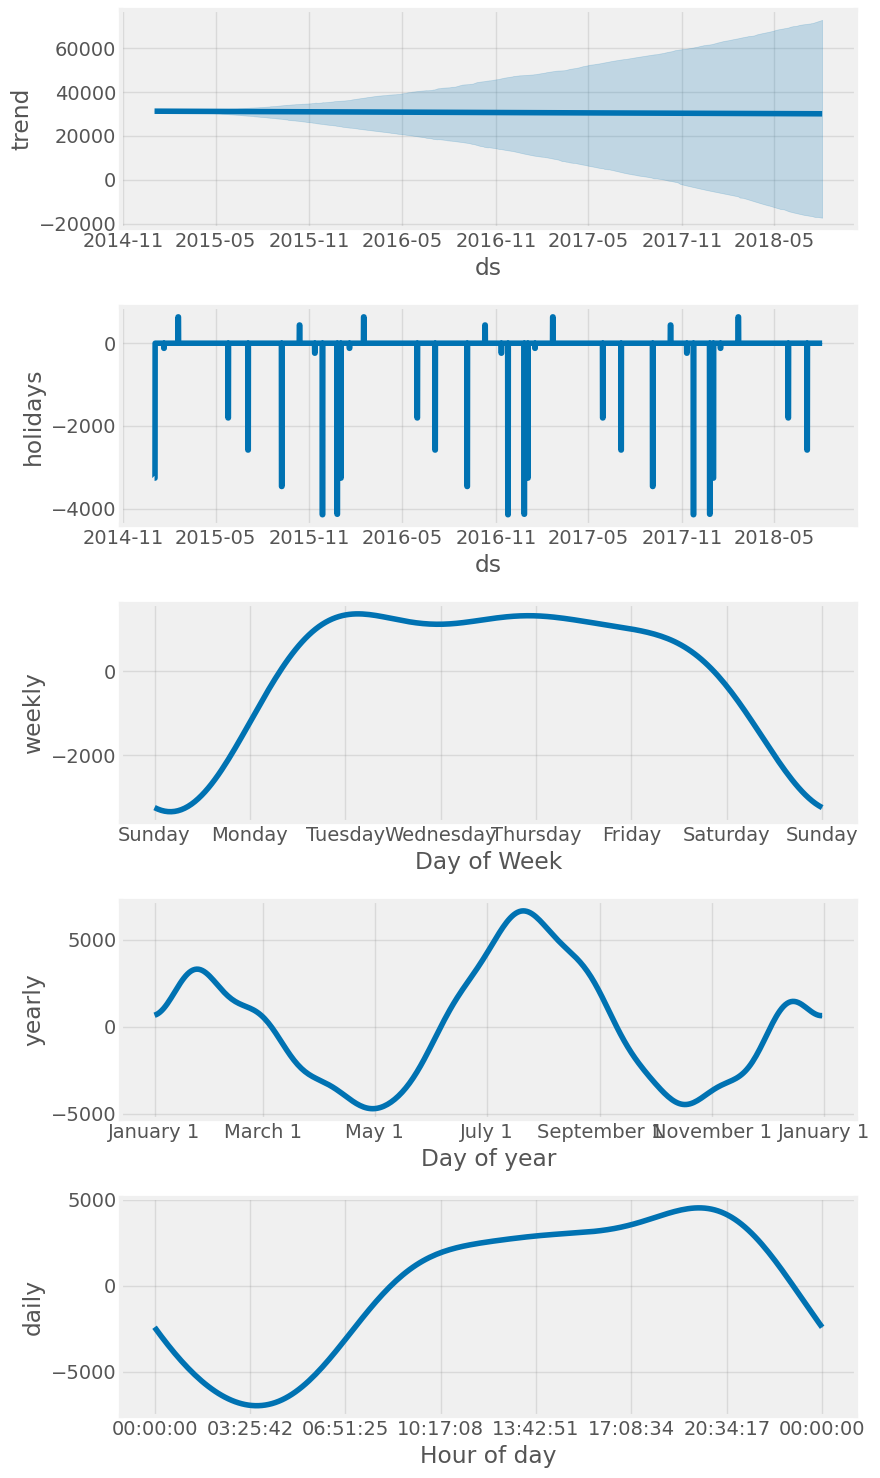

In [212]:
fig = model_with_holidays.plot_components(
    pjme_test_fcst_with_hols)
plt.show()

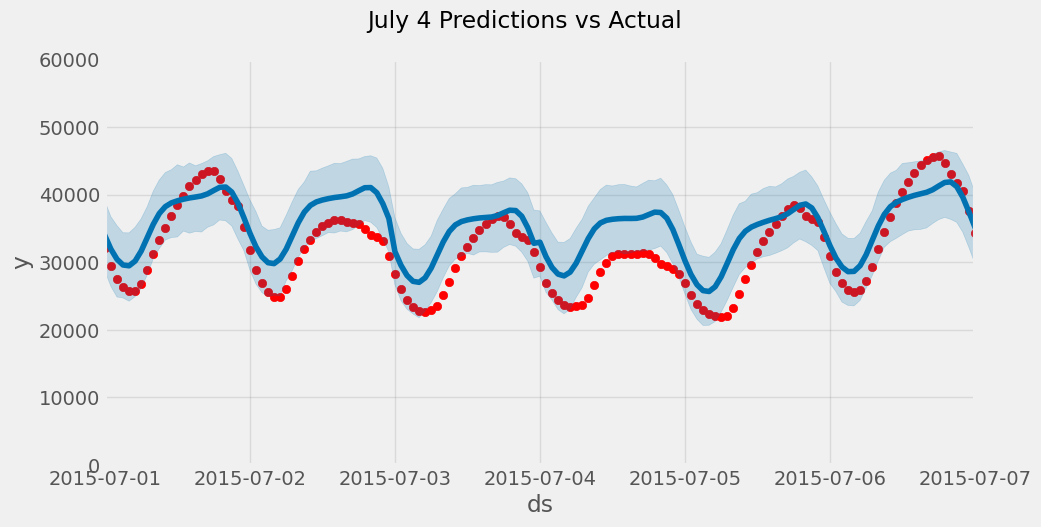

In [213]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)

# Convert the date strings to datetime objects using pd.to_datetime
lower_date = pd.to_datetime('2015-07-01')  # Changed format to 'YYYY-MM-DD'
upper_date = pd.to_datetime('2015-07-07')  # Changed format to 'YYYY-MM-DD'

ax.set_xbound(lower=lower_date, upper=upper_date)  # Now using datetime objects
ax.set_ylim(0, 60000)
plot = plt.suptitle('July 4 Predictions vs Actual')
plt.show()

In [214]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat']))

np.float64(6635.663701334185)

In [215]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

5198.953628812672

In [216]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

np.float64(16.562697535721984)

**Predict into the Future**

We can use the built in make_future_dataframe method to build our future dataframe and make predictions.

In [217]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [218]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,"Birthday of Martin Luther King, Jr.","Birthday of Martin Luther King, Jr._lower","Birthday of Martin Luther King, Jr._upper",Christmas Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31258.436150,20940.167463,29888.053458,31258.436150,31258.436150,0.0,0.0,0.0,0.0,...,1324.486469,1324.486469,1324.486469,644.962377,644.962377,644.962377,0.0,0.0,0.0,25537.447405
1,2015-01-01 02:00:00,31258.398345,19540.881055,28246.527494,31258.398345,31258.398345,0.0,0.0,0.0,0.0,...,1318.709534,1318.709534,1318.709534,645.896433,645.896433,645.896433,0.0,0.0,0.0,24035.495631
2,2015-01-01 03:00:00,31258.360540,18598.824166,27867.486396,31258.360540,31258.360540,0.0,0.0,0.0,0.0,...,1311.390687,1311.390687,1311.390687,646.864276,646.864276,646.864276,0.0,0.0,0.0,23165.961037
3,2015-01-01 04:00:00,31258.322735,18420.064206,27512.351071,31258.322735,31258.322735,0.0,0.0,0.0,0.0,...,1302.640782,1302.640782,1302.640782,647.865943,647.865943,647.865943,0.0,0.0,0.0,23026.348547
4,2015-01-01 05:00:00,31258.284930,19266.177580,28184.485348,31258.284930,31258.284930,0.0,0.0,0.0,0.0,...,1292.586562,1292.586562,1292.586562,648.901472,648.901472,648.901472,0.0,0.0,0.0,23702.320333


In [223]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2002-01-01 01:00:00,25752.186804
1,2002-01-01 02:00:00,24271.383972
2,2002-01-01 03:00:00,23419.484287
3,2002-01-01 04:00:00,23294.322922
4,2002-01-01 05:00:00,23981.954006
